In [2]:
import os
import io
import numpy as np
import matplotlib.pyplot as plt
import glob
import pandas as pd
import csv
import xlsxwriter as xlsx
from openpyxl import Workbook
import string
import re
from datetime import datetime
import rpy2.robjects as ro
import rpy2.robjects.numpy2ri
import seaborn as sns
from sklearn import svm

In [3]:
main = "/Users/danie/Desktop/Data" 
### T2 Baseline ###
workT2 = '001. T2 Baseline no shaker/20190418 BaselineTest_*.txt'
T2 = glob.glob(os.path.join(main, workT2))
### T3 Inner_ring (400mm) ###
workT3 = '002. T3 Inner ring damage no shaker/20190424 IR_Damage_*.txt'
T3 = glob.glob(os.path.join(main, workT3))
### T5 Inner_ring (100mm) ###
workT5 = '005. T5 Inner ring damage/20190718 - T5 IR damage SN17-12620_Rep_*.txt'
T5 = glob.glob(os.path.join(main, workT5))
### T9 Outer_ring (400mm) ###
workT9 = '011. T9 OR Damage FAG/20190826 - T9 Outer Ring Dmg  SN17-12628 - FAG_DAQ_*.txt'
T9 = glob.glob(os.path.join(main, workT9))
### T10 Outer_ring (200mm) ###
workT10 = '013. T10 OR Damage FAG/20190829 - T10 Outer Ring Dmg  S`N17-12626 - FAG_DAQ_*.txt'
T10 = glob.glob(os.path.join(main, workT10))
### T11 Outer_ring (100mm) ###
workT11 = '015. T11 OR Damage FAG/20190903 - T11 Outer Ring Dmg  SN17-12625 - FAG_DAQ_*.txt'
T11 = glob.glob(os.path.join(main, workT11))
### T12 Ball (400mm) ###
workT12 = '017. T12 Ball Damage FAG/20190911 - T12 Ball Dmg  SN17-12624 - FAG_DAQ_*.txt'
T12 = glob.glob(os.path.join(main, workT12))
### T13 Ball (100mm) ###
workT13 = '019. T13 Ball Damage FAG/20190916 - T13 Ball Dmg  SN17-12629 - FAG_DAQ_*.txt'
T13 = glob.glob(os.path.join(main, workT13))
### T14 Slippage ###
workT14 = '022. T14 Slippage FAG rep/20191010 - T14 Slippage SN17-12619 - FAG_DAQ_decreasing load - Rep_*.txt'
T14 = glob.glob(os.path.join(main, workT14))
### T15 Ball (mm) ###
workT15 = '023. T15 Ball Damage FAG/20191021 - T15 Ball Dmg  SN17-12627 - FAG_DAQ_*.txt'
T15 = glob.glob(os.path.join(main, workT15))

In [4]:
ro.numpy2ri.activate()
ro.r('''source('/Users/danie/Desktop/Data/R functions.R')''')
r_rpm = ro.globalenv['Tachometer.speed']
r_reduction = ro.globalenv['Sample.reduction']

In [5]:
#converting a list into a tuple(to be able to run in Matplotlib)
def convert(RRR):
    return tuple(RRR)

In [6]:
########## Time Interval (Seconds) ##########
### Creating a interval time in SECONDS using data from one folder ###
def time_delta(timedelta):
    number = 0
    time1_arrays = []
    for path in timedelta:
        number += 1
        with io.open(path, mode = 'r') as fd:
            time0_arrays = []
            df = pd.DataFrame([])
            time_reader = pd.read_csv(fd, nrows = 0, skiprows = 2, delimiter = ("\t"))
            for sentence in time_reader:
                remove = string.punctuation
                remove = remove.replace(",","")
                pattern = r"[{}]".format(remove)
                test_time = re.sub(pattern," ", str(sentence))
                splitted_time = str(test_time).split(' ')
                time0_arrays.append(splitted_time)
                time_split1 = np.array_split(time0_arrays, 1, axis = 0)
                time_split2 = time_split1[0]
                time_split3 = time_split2[0]
                time_split4 = time_split3[6:9]
                time1 = time_split4[0]+":"+time_split4[1]+":"+time_split4[2]
                FMT = '%H:%M:%S'
                if number == 1:
                    int_time = time1
                    time1_arrays.append(0)
                else:
                    tdelta = datetime.strptime(time1, FMT) - datetime.strptime(int_time, FMT)
                    tdelta = tdelta.total_seconds() 
                    time1_arrays.append(tdelta)
    return time1_arrays

In [7]:
########## Time DataFrame (Seconds) ##########
### Creating TIME DataFrame with the interval time(seconds) for one folder ###
def time_df(seconds_delta):
    timedf = pd.DataFrame()
    for no_time in range(len(seconds_delta)):
        time_arrays = []
        time = pd.Series(range(0,100000))
        time = time.div(100000, axis = 0)
        for time_column1 in range(0,1):
            x = 0
            y = 2001
            for time_row1 in range(50):
                time_a = time.iloc[x:y].mean(axis=0)  #averaging every 50 points
                time_arrays.append(time_a)
                x = x + 2000
                y = y + 2000
        time_ori = pd.DataFrame(time_arrays, columns = ['Time'])
        time_domain = time_ori.add(seconds_delta[no_time])
        global timedf1
        timedf = timedf.append(pd.DataFrame(time_domain))
        timedf1 = pd.concat([timedf], ignore_index = True)
    return timedf1

In [8]:
########## Axial & Radial Load ##########
### DataFrame of Axial Load and Radial Load from each folder ### 
def load(loads):
    load_df = pd.DataFrame()
    for file_load in loads: #reading multiple texts from a folder
        load_arrays = []
        with io.open(file_load, mode = 'r') as ld:
            load_reader = pd.read_csv(ld, delimiter = ("\t"), skiprows = 10, usecols = [13,14])
            for load_column in range(1):
                x = 0
                y = 2001
                for load_row in range(50):
                    load_reader1 = (load_reader.iloc[x:y].mean(axis=0))  #averaging every 50 points
                    load_arrays.append(load_reader1)  #adding it into an array 
                    x = x + 2000
                    y = y + 2000

            AL = [] #Axial_Load
            RL = [] #Radial_Load

            load_split1 = np.array_split(load_arrays, 50, axis = 0) #splitting arrays into multiple arrrays

            #Splitting each variable into it's own list
            for load_a in range(50):
                load_split2 = load_split1[load_a]
                load_split3 = load_split2[0]
                for load_b in range(2):
                    load_split4 = load_split3[load_b]
                    load_split5 = float(load_split4)
                    if load_b == 0:
                        AL.append(load_split5)
                    elif load_b == 1:
                        RL.append(load_split5)

            Axial_load = convert(AL)
            Radial_load= convert(RL)

            load_data = {'Axial_load': Axial_load,
                    'Radial_load': Radial_load,}

            #Append all datas into DataFrame
            global load_df1
            load_df = load_df.append(pd.DataFrame(load_data))
            load_df1 = pd.concat([load_df], ignore_index = True)
    return load_df1

In [9]:
########## Accelerometer Hor & Ver (BASE & IR) ##########
### Scaling vibration signals before averaging data for "TEST B+IR" by the 3 variables ###
def acc1(acc_hor_ver1):
    acc_df = pd.DataFrame()
    for file_acc1 in acc_hor_ver1:
        hor_arrays = []
        ver_arrays = [] 
        with io.open(file_acc1, mode = 'r') as acc:
            acc_reader = pd.read_csv(acc, delimiter = ("\t"), skiprows = 10, usecols = [7,8])
            acc_hor_reader = acc_reader['Acc_horizontal (g)']
            acc_ver_reader = acc_reader['Acc_vertical (g)']
            reader1 = acc_reader.iloc[0:100000].mean(axis=0)
            acc_hor_reader1 = acc_hor_reader - reader1[0]
            acc_ver_reader1 = acc_ver_reader - reader1[1]
            hor_ss = 2.454
            ver_ss = 2.366
            hor_ccf_1 = 2.45
            ver_ccf_1 = 2.36
            scaling_fac = 100
            acc_hor_reader2 = acc_hor_reader1*(scaling_fac*hor_ccf_1/hor_ss)
            acc_ver_reader2 = acc_ver_reader1*(scaling_fac*ver_ccf_1/ver_ss)
            for column1 in range(1):
                x = 0
                y = 2001
                for row1 in range(50):
                    acc_hor_reader2 = acc_hor_reader1.iloc[x:y].mean(axis=0)
                    acc_ver_reader2 = acc_ver_reader1.iloc[x:y].mean(axis=0) #averaging every 50 points
                    hor_arrays.append(acc_hor_reader2)  #adding it into an array 
                    ver_arrays.append(acc_ver_reader2)
                    x = x + 2000
                    y = y + 2000
            AH = []
            AV = []
            hor_split1 = np.array_split(hor_arrays, 50, axis = 0)
            ver_split1 = np.array_split(ver_arrays, 50, axis = 0)
            for hor_a in range(50):
                hor_split2 = hor_split1[hor_a]
                hor_split3 = hor_split2[0]
                hor_split4 = float(hor_split3)
                AH.append(hor_split4)
            for ver_a in range(50):
                ver_split2 = ver_split1[ver_a]
                ver_split3 = ver_split2[0]
                ver_split4 = float(ver_split3)
                AV.append(ver_split4)

            Acc_hor = convert(AH)
            Acc_ver = convert(AV)
            acc_data = {'Acc_Hor': Acc_hor,
                       'Acc_Ver': Acc_ver}
            global acc_df1
            acc_df = acc_df.append(pd.DataFrame(acc_data))
            acc_df1 = pd.concat([acc_df], ignore_index = True)
    return acc_df1

In [10]:
########## Accelerometer Hor & Ver (OR & BALL) ##########
### Scaling vibration signals before averaging data for "TEST Or+Ball" by the 3 variables ###
def acc2(acc_hor_ver2):
    acc_df = pd.DataFrame()
    for file_acc2 in acc_hor_ver2:
        hor_arrays = []
        ver_arrays = [] 
        with io.open(file_acc2, mode = 'r') as acc:
            acc_reader = pd.read_csv(acc, delimiter = ("\t"), skiprows = 10, usecols = [7,8])
            acc_hor_reader = acc_reader['Acc_horizontal (g)']
            acc_ver_reader = acc_reader['Acc_vertical (g)']
            reader1 = acc_reader.iloc[0:100000].mean(axis=0)
            acc_hor_reader1 = acc_hor_reader - reader1[0]
            acc_ver_reader1 = acc_ver_reader - reader1[1]
            hor_ss = 2.454
            ver_ss = 2.366
            hor_ccf_2 = 1.45
            ver_ccf_2 = 1.9
            scaling_fac = 100
            acc_hor_reader2 = acc_hor_reader1*(scaling_fac*hor_ccf_2/hor_ss)
            acc_ver_reader2 = acc_ver_reader1*(scaling_fac*ver_ccf_2/ver_ss)
            for column1 in range(1):
                x = 0
                y = 2001
                for row1 in range(50):
                    acc_hor_reader2 = acc_hor_reader1.iloc[x:y].mean(axis=0)
                    acc_ver_reader2 = acc_ver_reader1.iloc[x:y].mean(axis=0) #averaging every 50 points
                    hor_arrays.append(acc_hor_reader2)  #adding it into an array 
                    ver_arrays.append(acc_ver_reader2)
                    x = x + 2000
                    y = y + 2000
            AH = []
            AV = []
            hor_split1 = np.array_split(hor_arrays, 50, axis = 0)
            ver_split1 = np.array_split(ver_arrays, 50, axis = 0)
            for hor_a in range(50):
                hor_split2 = hor_split1[hor_a]
                hor_split3 = hor_split2[0]
                hor_split4 = float(hor_split3)
                AH.append(hor_split4)
            for ver_a in range(50):
                ver_split2 = ver_split1[ver_a]
                ver_split3 = ver_split2[0]
                ver_split4 = float(ver_split3)
                AV.append(ver_split4)

            Acc_hor = convert(AH)
            Acc_ver = convert(AV)
            acc_data = {'Acc_Hor': Acc_hor,
                       'Acc_Ver': Acc_ver}
            global acc_df1
            acc_df = acc_df.append(pd.DataFrame(acc_data))
            acc_df1 = pd.concat([acc_df], ignore_index = True)
    return acc_df1

In [11]:
########## Tachometer Speed ##########
def tacho_s(tacho_speed):
    ts_df1 = pd.DataFrame()
    ts_df = pd.DataFrame()
    ts_arrays = []
    for tacho_file in tacho_speed:
        with io.open(tacho_file, mode = 'r') as ts:  
            ts_reader = pd.read_csv(ts, delimiter = ("\t"), skiprows = 10, usecols = [16])
            tacho_speeds = r_rpm(Data_input = ts_reader.values, Min_trigger = 3, Max_trigger = 4, Range_accept = 2, Min_accept = 4,
                          Tachometer_pulse = 6, Sampling_rate = 100000, Checks = False, Show_plot = False, Reforming = False,
                          R_From = 1, R_To = 5000, R_Multi = 1)
            ts_arrays.append(tacho_speeds[0])
    for tarrays_no in range(len(ts_arrays)):
        for rows in range(50):
            ts_df1.loc[rows, 'Shaft_speed'] = ts_arrays[tarrays_no]
        global ts_dfmain
        ts_df = ts_df.append(pd.DataFrame(ts_df1))
        ts_dfmain = pd.concat([ts_df], ignore_index = True)
    return ts_dfmain

In [12]:
file = "/Users/danie/Desktop/Data/001. T2 Baseline no shaker/20190418 BaselineTest_0033.txt" 
with io.open(file, mode = 'r') as path:
    re_reader = pd.read_csv(path, delimiter = ("\t"), skiprows = 10, usecols = [0, 7, 8])
    #print(re_reader)
    reduction = r_reduction( re_reader.values, sample_reduce = 2000, apply_filter = False, sampling_rate = 100000, R_n = 1,  R_from = 1, R_to = 50000, include_time = True)

In [13]:
print(reduction)

     Time       V2        V3       V4       V5         V6        V7       V8

1  990.00 1.859793 -5.350858 1.860099 5.354135 0.03376103 0.1873481 1.060899

2  990.02 1.859158 -5.363516 1.859484 5.366875 0.03477712 0.1899048 1.051277

3  990.04 1.860824 -5.378085 1.861146 5.381357 0.03464074 0.1876815 1.076443

4  990.06 1.860098 -5.380471 1.860374 5.383763 0.03202730 0.1882876 1.057209

5  990.08 1.859361 -5.377430 1.859654 5.380869 0.03303754 0.1924078 1.054459

6  990.10 1.860562 -5.375683 1.860866 5.378972 0.03362868 0.1881148 1.055397

7  990.12 1.860395 -5.383862 1.860698 5.387122 0.03360744 0.1874348 1.061726

8  990.14 1.859334 -5.392538 1.859627 5.395879 0.03299007 0.1899089 1.061909

9  990.16 1.860830 -5.409737 1.861117 5.412967 0.03269633 0.1870197 1.054650

10 990.18 1.860101 -5.433598 1.860382 5.436794 0.03231225 0.1864263 1.057116

11 990.20 1.859943 -5.449925 1.860249 5.453236 0.03377482 0.1900759 1.058561

12 990.22 1.860991 -5.454237 1.861270 5.457474 0.03225975 0.1879

In [14]:
timeT2 = time_df(time_delta(T2))
timeT3 = time_df(time_delta(T3))
timeT5 = time_df(time_delta(T5))
timeT9 = time_df(time_delta(T9))
timeT10 = time_df(time_delta(T10))
timeT11 = time_df(time_delta(T11))
timeT12 = time_df(time_delta(T12))
timeT13 = time_df(time_delta(T13))
#timeT14 = time_df(time_delta(T14))
timeT15 = time_df(time_delta(T15))

In [15]:
loadT2 = load(T2)
loadT3 = load(T3)
loadT5 = load(T5)
loadT9 = load(T9)
loadT10 = load(T10)
loadT11 = load(T11)
loadT12 = load(T12)
loadT13 = load(T13)
#loadT14 = load(T14)
loadT15 = load(T15)

In [16]:
accT2 = acc1(T2)
accT3 = acc1(T3)
accT5 = acc2(T5)
accT9 = acc2(T9)
accT10 = acc2(T10)
accT11 = acc2(T11)
accT12 = acc2(T12)
accT13 = acc2(T13)
#accT14 = acc2(T14)
accT15 = acc2(T15)

In [17]:
tachoT2 = tacho_s(T2)
tachoT3 = tacho_s(T3)
tachoT5 = tacho_s(T5)
tachoT9 = tacho_s(T9)
tachoT10 = tacho_s(T10)
tachoT11 = tacho_s(T11)
tachoT12 = tacho_s(T12)
tachoT13 = tacho_s(T13)
#tachoT14 = tacho_s(T14)
tachoT15 = tacho_s(T15)

In [18]:
type0 = np.zeros([])
type1 = np.ones([])
type2 = np.ones([]) + 1
type3 = np.ones([]) + 2
type4 = np.ones([]) + 3
df0 = pd.concat([timeT2, accT2, loadT2, tachoT2], axis = 1)
df0.insert(0, "Type", type0, True)
df1 = pd.concat([timeT3, accT3, loadT3, tachoT3], axis = 1)
df1.insert(0, "Type", type1, True)
df2 = pd.concat([timeT5, accT5, loadT5, tachoT5], axis = 1)
df2.insert(0, "Type", type1, True)
df3 = pd.concat([timeT9, accT9, loadT9, tachoT9], axis = 1)
df3.insert(0, "Type", type2, True)
df4 = pd.concat([timeT10, accT10, loadT10, tachoT10], axis = 1)
df4.insert(0, "Type", type2, True)
df5 = pd.concat([timeT11, accT11, loadT11, tachoT11], axis = 1)
df5.insert(0, "Type", type2, True)
df6 = pd.concat([timeT12, accT12, loadT12, tachoT12], axis = 1)
df6.insert(0, "Type", type3, True)
df7 = pd.concat([timeT13, accT13, loadT13, tachoT13], axis = 1)
df7.insert(0, "Type", type3, True)
#df7 = pd.concat([timeT14, accT14, loadT14, tachoT14], axis = 1)
#df7.insert(0, "Type", type4, True)
df8 = pd.concat([timeT15, accT15, loadT15, tachoT15], axis = 1)
df8.insert(0, "Type", type3, True)

In [19]:
main_df1 = pd.DataFrame()
for job in range(9):
    job1 = 'df'+ '%d'%job
    main_df1 = main_df1.append(eval(job1))
    main_df = pd.concat([main_df1], ignore_index = True, sort = True)
#cols = main_df.columns.tolist()
#cols = cols[-1:] + cols[:-1]
#main_df = main_df[cols]
main_df = main_df[['Type', 'Time', 'Acc_Hor', 'Acc_Ver', 'Axial_load', 'Radial_load', 'Shaft_speed']]

In [42]:
df2.to_excel("test.xlsx")

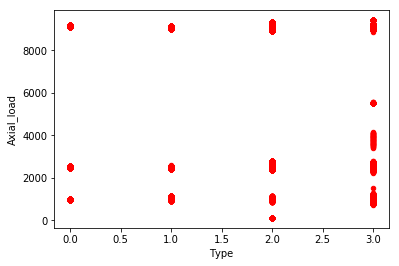

In [26]:
main_df.plot(kind = 'scatter', x = 'Type', y = 'Axial_load', color = 'red')
plt.show()

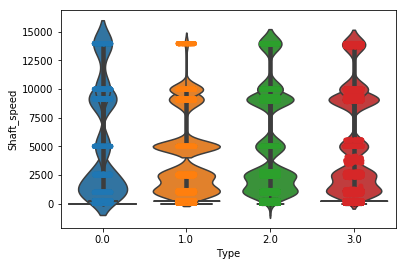

In [28]:
ax = sns.violinplot(x=main_df["Type"], y=main_df["Acc_Hor"])
ax = sns.stripplot(x=main_df["Type"], y=main_df["Acc_Hor"], jitter = True)
ax1 = sns.violinplot(x=main_df["Type"], y=main_df["Acc_Ver"])
ax1 = sns.stripplot(x=main_df["Type"], y=main_df["Acc_Ver"], jitter = True)
ax2 = sns.violinplot(x=main_df["Type"], y=main_df["Axial_load"])
ax2 = sns.stripplot(x=main_df["Type"], y=main_df["Axial_load"], jitter = True)
ax3 = sns.violinplot(x=main_df["Type"], y=main_df["Radial_load"])
ax3 = sns.stripplot(x=main_df["Type"], y=main_df["Radial_load"], jitter = True)
ax4 = sns.violinplot(x=main_df["Type"], y=main_df["Shaft_speed"])
ax4 = sns.stripplot(x=main_df["Type"], y=main_df["Shaft_speed"], jitter = True)

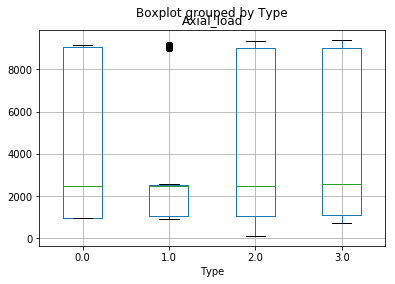

In [46]:
main_df.boxplot(column = 'Axial_load', by = 'Type')

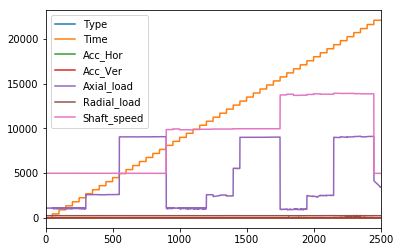

In [27]:
df7.plot()

In [ ]:
arrays = []
path = "/Users/danie/Desktop/Data/001. T2 Baseline no shaker/20190418 BaselineTest_0033.txt"
with open(path,'r') as f:
    reader = pd.read_csv(f)
    reader.dropna(inplace = True)
    #reader["SG_Outer_L (um/m)"]=reader["SG_Outer_L (um/m)"].str.split("t", n=1, expand=True)
    #print(reader)
    #print(reader)
    #print(reader.iloc[0])
    #for column in range(0,17):
     #   tempoValue = 0
      #  totalValue = 0
       # row_count = 0
        #for row in range(1,100001):
         #       row_count = row_count + 1
          #      tempoValue = (reader.iloc[row][column])
           #     totalValue = float(tempoValue) + float(totalValue)
            #    if row_count == 50:
             #       averageValue = totalValue / row_count
              #      arrays.append(averageValue)
               #     totalValue = 0
                #    row_count = 0

#print(arrays)
#df = pd.DataFrame(arrays[1:], columns=arrays[0])